## Part 2: Transformer-Based Approach

This section implements the conventional approach using transformers to generate Shakespeare sonnets. While the data preprocessing and n-gram methodology remain similar to the diffusion model approach, the key differences lie in the network architecture and training strategy. Unlike diffusion models that denoise embeddings, transformers leverage attention mechanisms to learn sequential dependencies and generate coherent text autoregressively.

### Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

#import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.20.0


Run Below cell for GPU Utilization if available

In [2]:
strategy = tf.distribute.get_strategy()
print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


### **Preprocessing Shakespeare Text**

Here we convert punctuations to special symbols remove numbers to focus on words or linguistic patterns

In [3]:
def clean_numbers(text):
    pattern = r"[\d-]"
    return re.sub(pattern, '', text)

In [4]:
text = ''
print( "Reading txt file...")
#with open('D:/user/docs/NU/_Info6106/Lecture 10/data/shakespeare-sonnets.txt', 'r') as f:
with open('data/shakespeare-sonnets.txt', 'r') as f:
    text = f.read()

# sentence delimiter processing
text = text.replace(",\n", " _eol_ ")
text = text.replace(",", " _comma_  ")
# text = text.replace(":", " _comma_  ")
text = text.replace(";", " _comma_  ")

text = text.replace("?\n", ". ")
text = text.replace("!\n", ". ")
text = text.replace(".\n", ". ")
text = text.replace("?", ".")
text = text.replace("!", ".")
text = text.replace(":", ".")

text = text.replace('"',"")

# i leave apostrophes in place, spawning separate words
#text = text.replace("’","")

# absorb tabs
text = text.replace("\t", "")
text = text.replace("  ", "")

# remove numbes
text = clean_numbers(text)

# absorb soace
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")
text = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()

# removing contractions
text = re.sub(r"i'm", "i am", text)
text = re.sub(r"he's", "he is", text)
text = re.sub(r"she's", "she is", text)
text = re.sub(r"it's", "it is", text)
text = re.sub(r"that's", "that is", text)
text = re.sub(r"what's", "that is", text)
text = re.sub(r"where's", "where is", text)
text = re.sub(r"how's", "how is", text)
text = re.sub(r"\'ll", " will", text)
text = re.sub(r"\'ve", " have", text)
text = re.sub(r"\'re", " are", text)
text = re.sub(r"\'d", " would", text)
text = re.sub(r"\'re", " are", text)
text = re.sub(r"won't", "will not", text)
text = re.sub(r"can't", "cannot", text)
text = re.sub(r"n't", " not", text)
text = re.sub(r"n'", "ng", text)
text = re.sub(r"'bout", "about", text)

print('done!')

Reading txt file...
done!


In [5]:
text = text.lower()
text = text.replace('i ', 'I ')

In [6]:
len(text)

106075

### Creating Ngrams from the text

Since we are working to train the model to create poems or sonnets from shakespeare text, we use ngrams to structutre our dataset to help the model understand how a poem normally starts and ends as well as what words follow other words.

Having this type of dataset is especially important when we are training in poems as the sentence strucutre do not follow the norm and it is difficult to understand the pattern of each sentence. So having multiple examples of differant sequence lengths is really helpful

In [7]:
from tqdm import tqdm
from collections import Counter
from nltk import ngrams

ngrams_up_to_20 = []
for i in tqdm(range(2, 21)):
    ngram_counts = Counter(ngrams(text.split(), i))
    print('ngram-', i, 'length:', len(ngram_counts))
    ngrams_up_to_20.append(ngram_counts)

 32%|███▏      | 6/19 [00:00<00:00, 57.72it/s]

ngram- 2 length: 14004
ngram- 3 length: 18742
ngram- 4 length: 19387
ngram- 5 length: 19468
ngram- 6 length: 19493
ngram- 7 length: 19508
ngram- 8 length: 19521
ngram- 9 length: 19532
ngram- 10 length: 19542
ngram- 11 length: 19552
ngram- 12 length: 19559


100%|██████████| 19/19 [00:00<00:00, 47.64it/s]

ngram- 13 length: 19566
ngram- 14 length: 19573
ngram- 15 length: 19579
ngram- 16 length: 19584
ngram- 17 length: 19587
ngram- 18 length: 19589
ngram- 19 length: 19591
ngram- 20 length: 19592


In [8]:
ngrams_up_to_20[2].most_common(10)

[(('_comma_', 'why', 'dost', 'thou'), 3),
 (('when', 'I', 'have', 'seen'), 3),
 (('_comma_', 'some', 'in', 'their'), 3),
 (('_eol_', 'some', 'in', 'their'), 3),
 (('fair', '_comma_', 'kind', '_comma_'), 3),
 (('_comma_', 'kind', '_comma_', 'and'), 3),
 (('kind', '_comma_', 'and', 'true'), 3),
 (('for', 'I', 'have', 'sworn'), 3),
 (('the', 'treasure', 'of', 'thy'), 2),
 (('is', 'the', 'time', 'that'), 2)]

In [9]:
training_data = text.split('.')
for i in range(len(training_data)):
    training_data[i] = training_data[i].strip()
training_data[0:4]

["from fairest creatures we desire increase _eol_ that thereby beauty's rose might never die _eol_ but _comma_ as the riper should by time decease _eol_ his tender heir might bear his memory",
 "but thou _comma_ contracted to thine own bright eyes _eol_ feed'st thy light's flame with selfsubstantial fuel _eol_ making a famine where abundance lies _eol_ thyself thy foe _comma_ to thy sweet self too cruel",
 "thou that art now the world's fresh ornament and only herald to the gaudy spring within thine own bud buriest thy content and _comma_ tender churl _comma_ mak'st waste in niggarding",
 "pity the world _comma_ or else this glutton be to eat the world's due _comma_ by the grave and thee"]

In [10]:
dictionary = set()
for s in training_data:
    words = s.split()
    for word in words:
        dictionary.add(word)

len(dictionary)

3228

#### Tokenizer

- We use Keras Tokenizer to create word-to-integer mappings
- VOCAB_SIZE includes START_TOKEN and END_TOKEN for sequence boundaries

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer()

# Set the maximum sequence length for padding
max_sequence_length = 50

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(training_data)

# Convert the training data into sequences of tokens
sequences = tokenizer.texts_to_sequences(training_data)

# Pad the sequences to have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [13]:
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = len(dictionary), len(dictionary) + 1

# Vocabulary size plus start and end token
VOCAB_SIZE = len(dictionary) + 2

VOCAB_SIZE, START_TOKEN, END_TOKEN

(3230, 3228, 3229)

Filter out ngrams that are at the end of sentences (We add end of sentance examples later)

In [14]:
def remove_periods(ngram):
    for wrd in ngram[0]:
        if '.' in wrd or "’" in wrd or "‘" in wrd:
            return False
    return True

def my_filter(ngrams):
    return filter(remove_periods, ngrams)

In [15]:
import random

def fisher_yates (arr1, arr2):

    # We will Start from the last element
    # and swap one by one.
    n = len(arr1)
    if n != len(arr2):
        return None

    for i in range(n - 1, 0, -1):

        # Pick a random index from 0 to i
        j = random.randint(0, i)
        #print(i, j)

        # Swap arr[i] with the element at random index
        arr1[i], arr1[j] = arr1[j], arr1[i]
        arr2[i], arr2[j] = arr2[j], arr2[i]

    return arr1, arr2

In the below cells first words examples, end of sentance examples and our ngram examples with the above mentioned filter applied are all created and added to our dataset

#### First words

In [16]:
first_word_counts = Counter([ p.replace('. ', '') for p in re.findall('\..[^" "]*', text.lower())])
first_word_counts.most_common(10)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\yohan\AppData\Local\Temp\ipykernel_24392\1984571126.py:1: SyntaxWarning: invalid escape sequence '\.'
  first_word_counts = Counter([ p.replace('. ', '') for p in re.findall('\..[^" "]*', text.lower())])


[('o', 49),
 ('but', 41),
 ('for', 31),
 ('then', 25),
 ('so', 24),
 ('the', 24),
 ('if', 23),
 ('i', 20),
 ('and', 17),
 ('how', 15)]

In [17]:
y_train = [[tokenizer.word_index[w[0]]] for w,_ in first_word_counts.most_common() if w[0] in tokenizer.word_index and w[0] != '[]']
X_train = [[START_TOKEN] for i in range(len(y_train))]

X_train[0:5], y_train[0:5]

([[3228], [3228], [3228], [3228], [3228]], [[58], [8], [8], [19], [8]])

**Adding Bigrams**

In [18]:
ngrams_up_to_20[0].most_common()[0]

(('_eol_', 'and'), 150)

In [19]:
bigrams_to_learn = ngrams_up_to_20[0]
X_train_2 = [[tokenizer.word_index[sent[0][0]]] for sent in my_filter(bigrams_to_learn.most_common())
                  if sent[0][0] in tokenizer.word_index and sent[0][1] in tokenizer.word_index]
y_train_2 = [[tokenizer.word_index[sent[0][1]]] for sent in my_filter(bigrams_to_learn.most_common())
                  if sent[0][0] in tokenizer.word_index and sent[0][1] in tokenizer.word_index]
X_train_2, y_train_2 = fisher_yates(X_train_2, y_train_2)

X_train.extend(X_train_2)
y_train.extend(y_train_2)

In [20]:
random.sample(list(zip(X_train, y_train)), 10)

[([354], [6]),
 ([14], [39]),
 ([27], [613]),
 ([32], [512]),
 ([2027], [2028]),
 ([22], [1254]),
 ([98], [171]),
 ([35], [374]),
 ([38], [216]),
 ([1050], [2226])]

Rest of ngrams (up to 20)

In [21]:
from tqdm import tqdm

for i in tqdm(range(1, len(ngrams_up_to_20))):
    ngrams_to_learn = ngrams_up_to_20[i]
    X_train_2 = [[tokenizer.word_index[w] for w in sent[0][:-1]] for sent in my_filter(ngrams_to_learn.most_common())
                   if all([w in tokenizer.word_index for w in sent[0]])]
    y_train_2 = [[tokenizer.word_index[w] for w in sent[0][1:]] for sent in my_filter(ngrams_to_learn.most_common())
                   if all([w in tokenizer.word_index for w in sent[0]])]
    #X_train_2 = X_train_2[:2000]
    #y_train_2 = y_train_2[:2000]
    X_train_2, y_train_2 = fisher_yates(X_train_2, y_train_2)
    X_train.extend(X_train_2)
    y_train.extend(y_train_2)

100%|██████████| 18/18 [00:02<00:00,  6.92it/s]


In [22]:
len(X_train), len(y_train)

(61550, 61550)

In [23]:
print(random.sample(list(zip(X_train, y_train)), 10))

[([10, 11, 234, 3, 155, 4, 131, 12, 1408, 62, 14, 4, 51, 9, 131, 64, 216], [11, 234, 3, 155, 4, 131, 12, 1408, 62, 14, 4, 51, 9, 131, 64, 216, 235]), ([2928, 2929, 4, 2930, 924, 9], [2929, 4, 2930, 924, 9, 47]), ([65, 85, 880, 1388], [85, 880, 1388, 11]), ([567, 6], [6, 768]), ([608, 5, 259, 6, 1369, 448, 1370, 6, 124, 261, 36, 6], [5, 259, 6, 1369, 448, 1370, 6, 124, 261, 36, 6, 404]), ([305, 10, 593, 11, 1829, 1830, 14, 11, 1831], [10, 593, 11, 1829, 1830, 14, 11, 1831, 3]), ([320, 267, 125, 86, 663, 61, 12, 59, 45, 320, 7], [267, 125, 86, 663, 61, 12, 59, 45, 320, 7, 65]), ([99, 42, 22, 11, 934, 3, 71, 671, 9, 12], [42, 22, 11, 934, 3, 71, 671, 9, 12, 39]), ([1998, 68], [68, 305]), ([97, 257, 22, 23, 11], [257, 22, 23, 11, 97])]


In [24]:
tokenizer.sequences_to_texts([[79, 443], [443, 7], [5, 4, 802], [4, 802, 7]])

['see barren', 'barren of', 'to the edge', 'the edge of']

In [25]:
tokenizer.sequences_to_texts([l[0] + [1] + l[1] for l in random.sample(list(zip(X_train, y_train)), 10)])

['doth thy lays esteem and gives comma thy lays esteem and gives thy',
 'which for memorial comma for memorial still',
 'those hours that with gentle work did frame the lovely gaze where every eye doth dwell will comma hours that with gentle work did frame the lovely gaze where every eye doth dwell will play',
 'with heavenly comma heavenly alchemy',
 "in thy power dost hold time's fickle comma thy power dost hold time's fickle glass",
 'guilt should do thee comma should do thee shame',
 'whence hast thou this comma hast thou this becoming',
 'their character with golden quill and precious phrase by all comma character with golden quill and precious phrase by all the',
 'wardrobe which the robe doth hide to make some special comma which the robe doth hide to make some special instant',
 'steals mengs eyes and comma mengs eyes and womengs']

End of sentences

In [26]:
print( [tokenizer.word_index[w] for w in training_data[100].replace('_eol_', 'eol').split()] )

[62, 79, 44, 165, 567, 54, 15, 54, 40, 468]


In [27]:
import random
last_n_words = []
for i in tqdm(range(3, 21)):
    tokenized_sentences_500 = random.sample(list(sequences), 500)
    for s in tokenized_sentences_500:
        last_n_words.append(s[::-1][:i][::-1])

print(random.sample(last_n_words, 10))

100%|██████████| 18/18 [00:00<00:00, 660.09it/s]

[[12, 59, 113, 3, 79, 11, 285, 1406, 29, 12, 1407, 31, 317], [8, 78, 113], [65, 85, 880, 1388, 11, 881, 3, 1, 312, 882, 1, 883, 314, 10, 1389], [2203, 142, 5, 92, 19, 614, 115, 38, 614, 363, 2, 360, 138, 169, 2204, 127, 235, 1204], [78, 437, 76, 8, 87, 16, 1021, 57, 22, 571], [2, 3, 26, 10, 117, 274, 436, 170, 128], [238, 15, 133, 25, 11, 521, 7, 165], [31, 3, 10, 6, 382], [136, 5, 17, 1, 136, 5, 157, 180, 2, 8, 830, 67, 261, 10, 620, 259], [2595, 6, 706, 491, 429, 2, 2596, 6, 297, 3, 1262, 17, 302]]


In [28]:
X_train_eos = []
y_train_eos = []
for s in last_n_words:
    if 1 < len(s):
        X_train_eos.append(s)
        y_train_eos.append(s[1:] + [END_TOKEN])

In [29]:
X_train_eos[:2], y_train_eos[:2]

([[112, 3227, 22], [5, 516, 17]], [[3227, 22, 3229], [516, 17, 3229]])

In [30]:
len(X_train_eos)

8985

In [31]:
X_train.extend(X_train_eos)
y_train.extend(y_train_eos)

### Padding
Let's pad our dataset

In [32]:
max = 0
for i in range(len(X_train)):
    if max < len(X_train[i]):
        max = len(X_train[i])
max

20

Almost all sentences are below 20 words so we give 20 as padding value

In [33]:
MAX_LENGTH = 20

X_train_p = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
y_train_p = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')

In [34]:
X_train_p[20000]

array([2287,  289,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [35]:
y_train_p[20000]

array([289,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Create Final Dataset

In [36]:
# For tf.data.Dataset
BATCH_SIZE = 64
BUFFER_SIZE = 20000

**While creating the dataset:**

- The decoder input gets the target sequence up untill but not including the last word
- The outputs have all the sequence except the last word

This shifted sequence enables proper teacher forcing during training and the decoder predicts the next word given all previous words.

The predicted word is compared with the actual target to compute the loss

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_train_p,
        # Take everything except the last token for input
        'dec_inputs': y_train_p[:, :-1]
    },
    {
        # Take everything except the first token for target (prediction)
        'outputs': y_train_p[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
for (batch, (inp, tar)) in enumerate(dataset):
    print("input:", inp)
    print()
    print("output:", tar)
    break

input: {'inputs': <tf.Tensor: shape=(64, 20), dtype=int32, numpy=
array([[  6,   0,   0, ...,   0,   0,   0],
       [ 66,   9,   0, ...,   0,   0,   0],
       [349,   0,   0, ...,   0,   0,   0],
       ...,
       [ 46, 638,   0, ...,   0,   0,   0],
       [ 62,  27,   0, ...,   0,   0,   0],
       [713,   3,   0, ...,   0,   0,   0]], shape=(64, 20), dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 19), dtype=int32, numpy=
array([[1187,    0,    0, ...,    0,    0,    0],
       [   9,  422,    0, ...,    0,    0,    0],
       [  55,    0,    0, ...,    0,    0,    0],
       ...,
       [ 638,   61,    0, ...,    0,    0,    0],
       [  27,  442,    0, ...,    0,    0,    0],
       [   3,  227,    0, ...,    0,    0,    0]],
      shape=(64, 19), dtype=int32)>}

output: {'outputs': <tf.Tensor: shape=(64, 19), dtype=int32, numpy=
array([[  0,   0,   0, ...,   0,   0,   0],
       [422,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
 

### Transformer and Model Component Definitions (Object Oriented Aproach)

In [39]:
def scaled_dot_product_attention(q, k, v, attention_mask=None):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = tf.cast(matmul_qk, tf.float32) / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if attention_mask is not None:
        #scaled_attention_logits += (mask * -1e9)
        scaled_attention_logits += (tf.cast(attention_mask, tf.float32) * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    #output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, tf.cast(v, tf.float32))

    return output, attention_weights

In [40]:
query = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
key = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
value = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
mask = tf.random.uniform((4, 4), dtype=tf.int64, minval=0, maxval=200)
fn_out, fn_w = scaled_dot_product_attention(query, key, value, attention_mask=mask)
fn_out.shape, fn_w.shape

(TensorShape([4, 128]), TensorShape([4, 4]))

In [41]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name=None):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

    def call(self, v, k, q, attention_mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, attention_mask=attention_mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [42]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, attention_mask=None)  # me - changed from mask to attention_mask
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

**Masking**

`create_padding_mask`: Prevents attention to padding tokens so only the actual words fromd sonnet are trained on

In [43]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [44]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### Positional encoding

- Helps the model understand the positioning of words in the sequence
- we have used sinusoidal positional encoding for its ability to handle different sequence lengths from our ngram dataset

In [45]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Dense Layer

In [46]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

#### Encoding

In [47]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=True, mask=None):
        attn_output, _ = self.mha(x, x, x, attention_mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

We create samples to test the class calling and functioning

In [48]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), training=False, mask=None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [49]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=True, mask=None):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

In [50]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 20), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 20, 512)


#### Decoder layer and Decoder

In [51]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, attention_mask=padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

In [52]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 20, 512)), sample_encoder_layer_output,
    training=True, look_ahead_mask=None, padding_mask=None)
sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 20, 512])

In [53]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False,
           look_ahead_mask=None, padding_mask=None):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training,
                                                 look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

In [54]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 20), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 20, 512]), TensorShape([64, 8, 20, 20]))

### Transformer

- Encoder + Decoder + Final projection layer

In the transformer, we pass the input sequence from the dataset, encoder encodes it to its representation, which is then given to the decoder and it gives a contextualized output (with the help of self attention heads in both encoder and decoder and cross-attention in the decoder). The decoder output is then passed through a dense layer which gives the logits for each vocabulary word (we take the highest probable one)

In [55]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training=False, enc_padding_mask=None,
           look_ahead_mask=None, dec_padding_mask=None):

        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

In [56]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 20), dtype=tf.int32, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 20), dtype=tf.int32, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 20, 8000])

#### Loss function

Uses Sparse Categorical Crossentropy to

- Ignore padding tokens (0) when computing loss
- Prevents model from learning to predict padding

In [57]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

Using `CustomScheduleFloat` for better stability since its casts float32 to avoid dtype issues

In [58]:
class CustomScheduleFloat(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomScheduleFloat, self).__init__()

        self.d_model = tf.constant(d_model,dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.cast(tf.math.rsqrt(tf.cast(step, tf.float32)), tf.float32)
        arg2 = tf.cast(tf.cast(step, tf.float32) * (tf.cast(self.warmup_steps, tf.float32)**-1.5), tf.float32)

        size = tf.cast(tf.math.rsqrt(self.d_model), tf.float32)
        return tf.math.multiply(size, tf.math.minimum(arg1, arg2))

In [59]:
sample_learning_rate = CustomScheduleFloat(d_model=128)

Text(0.5, 0, 'Train Step')

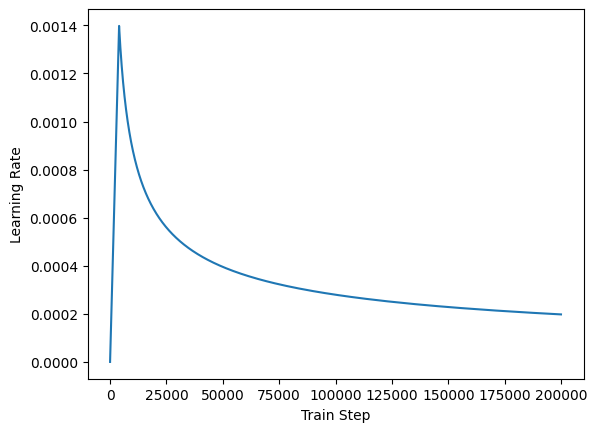

In [60]:
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- `create_look_ahead_mask`:Prevents decoder from seeing future tokens during training

In [61]:
def create_look_ahead_mask(x):
    # Extract the sequence length dynamically from the tensor x
    seq_len = tf.shape(x)[1]

    # Create the matrix (seq_len, seq_len)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

    return look_ahead_mask

- `enc_padding_mask`: For encoder self-attention
    - Prevents attention to padding in input sequence

- `combined_mask`: For decoder self-attention
    - Combination of look-ahead mask + padding mask
    - Prevents seeing future tokens and attention to padding

- `dec_padding_mask`: For decoder cross-attention to encoder
    - Prevents decoder from attention to padding in encoder output

In [62]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    #look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    look_ahead_mask = create_look_ahead_mask(tar)
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

### Create and Train the Model

We use the hyper parameters below

In [63]:
# Maximum sentence length
MAX_LENGTH = 20

# For Transformer
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.15

EPOCHS = 40

In [64]:
learning_rate = CustomScheduleFloat(d_model=D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
tf.keras.backend.clear_session()

transformer = Transformer(num_layers=NUM_LAYERS, d_model=D_MODEL, num_heads=NUM_HEADS, dff=UNITS,
                          input_vocab_size=VOCAB_SIZE, target_vocab_size=VOCAB_SIZE,
                          pe_input=VOCAB_SIZE,
                          pe_target=VOCAB_SIZE,
                          rate=DROPOUT)

transformer.compile(optimizer=optimizer, loss=loss_function)

In [65]:
import os

checkpoint_path = "./data/training_checkpoints/transformer"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    print(f"Created checkpoint directory: {checkpoint_path}")
else:
    print(f"Checkpoint directory already exists: {checkpoint_path}")

# Links the checkpoint to your specific model and optimizer
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# 4. Create the CheckpointManager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # 5. Restore the latest checkpoint if it exists
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('Latest checkpoint restored!!')
# else:
#     print('No checkpoint found. Initializing from scratch.')

Checkpoint directory already exists: ./data/training_checkpoints/transformer


In [66]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:

@tf.function
def train_step(inp, dec_inp, tar):
    """
    inp: encoder input
    dec_inp: decoder input (already has START_TOKEN prepended, last token removed)
    tar: target outputs (labels for loss calculation)
    """
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(dec_inp)
    dec_target_padding_mask = create_padding_mask(dec_inp)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp,
            dec_inp,
            training=True,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        # Calculate loss against tar (full target sequence)
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar, predictions)

In [ ]:
# The actual training loop
EPOCHS = 40  # Set your desired epochs
for epoch in range(EPOCHS):
    for (batch, (inp_dict, tar_dict)) in enumerate(dataset):
        source = inp_dict['inputs']
        dec_input = inp_dict['dec_inputs']
        target = tar_dict['outputs']

        train_step(source, dec_input, target)  # Pass all three

        if batch % 200 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))

Epoch 1 Batch 0 Loss 8.3717 Accuracy 0.0000
Epoch 1 Batch 200 Loss 7.3641 Accuracy 0.0014
Epoch 1 Batch 400 Loss 6.6356 Accuracy 0.0098
Epoch 1 Batch 600 Loss 5.8688 Accuracy 0.0332
Epoch 1 Batch 800 Loss 5.0072 Accuracy 0.0774
Epoch 1 Loss 4.5913 Accuracy 0.0986
Epoch 2 Batch 0 Loss 4.5908 Accuracy 0.0985
Epoch 2 Batch 200 Loss 4.5705 Accuracy 0.0831
Epoch 2 Batch 400 Loss 4.2401 Accuracy 0.0801
Epoch 2 Batch 600 Loss 3.8103 Accuracy 0.0948
Epoch 2 Batch 800 Loss 3.4297 Accuracy 0.1188
Epoch 2 Loss 3.2550 Accuracy 0.1296
Epoch 3 Batch 0 Loss 3.2552 Accuracy 0.1296
Epoch 3 Batch 200 Loss 3.2780 Accuracy 0.1185
Epoch 3 Batch 400 Loss 3.1242 Accuracy 0.1145
Epoch 3 Batch 600 Loss 2.9214 Accuracy 0.1213
Epoch 3 Batch 800 Loss 2.7309 Accuracy 0.1355
Epoch 3 Loss 2.6414 Accuracy 0.1418
Epoch 4 Batch 0 Loss 2.6419 Accuracy 0.1418
Epoch 4 Batch 200 Loss 2.7109 Accuracy 0.1332
Epoch 4 Batch 400 Loss 2.6421 Accuracy 0.1293
Epoch 4 Batch 600 Loss 2.5336 Accuracy 0.1328
Epoch 4 Batch 800 Loss 2.4

With 40 epochs, We got the loss down to 0.66 and the accuracy up to 18%. The accuracy did not increased steadly from 1-20 epochs (16%), however, after that it started to plateau and learning did not improve much after 18%

**Save model weights and Info**

In [129]:
transformer.save_weights('data/shakespeare_weights.weights.h5')
print("✅ Weights saved")

✅ Weights saved


In [128]:
import pickle

model_data = {
    'tokenizer': tokenizer,
    'START_TOKEN': START_TOKEN,
    'END_TOKEN': END_TOKEN,
    'VOCAB_SIZE': VOCAB_SIZE,
    'MAX_LENGTH': MAX_LENGTH,
    'NUM_LAYERS': NUM_LAYERS,
    'D_MODEL': D_MODEL,
    'NUM_HEADS': NUM_HEADS,
    'UNITS': UNITS,
    'DROPOUT': DROPOUT
}

with open('data/model_data.pkl', 'wb') as f:
    pickle.dump(model_data, f)

**Load Model**

In [68]:
import pickle

# Load model_data.pkl
with open('data/model_data.pkl', 'rb') as f:
    model_data = pickle.load(f)

tokenizer = model_data['tokenizer']
START_TOKEN = model_data['START_TOKEN']
END_TOKEN = model_data['END_TOKEN']
VOCAB_SIZE = model_data['VOCAB_SIZE']
MAX_LENGTH = model_data['MAX_LENGTH']
D_MODEL = model_data['D_MODEL']
NUM_HEADS = model_data['NUM_HEADS']
DROPOUT = model_data['DROPOUT']

print("✅ Tokenizer and constants loaded")
print(f"   VOCAB_SIZE: {VOCAB_SIZE}, START: {START_TOKEN}, END: {END_TOKEN}")

# Recreate the EXACT model architecture
transformer = Transformer(num_layers=NUM_LAYERS, d_model=D_MODEL, num_heads=NUM_HEADS, dff=UNITS,
                          input_vocab_size=VOCAB_SIZE, target_vocab_size=VOCAB_SIZE,
                          pe_input=VOCAB_SIZE,
                          pe_target=VOCAB_SIZE,
                          rate=DROPOUT)

# Build model with dummy forward pass
dummy_inp = tf.random.uniform((1, 20), dtype=tf.int32, minval=0, maxval=100)
dummy_tar = tf.random.uniform((1, 19), dtype=tf.int32, minval=0, maxval=100)
_ = transformer(dummy_inp, dummy_tar, training=False)

print("✅ Model architecture created")

# Load the trained weights
transformer.load_weights('data/shakespeare_weights.weights.h5')

✅ Tokenizer and constants loaded
   VOCAB_SIZE: 3291, START: 3289, END: 3290
✅ Model architecture created


### Inference

We have used two ways to generate the output id or token from the model.

Greedy Sampling: Looks at the predicted probabilities in the vocabulary and always picks the word with highest probability. It gives consistent outputs, but may get stuck in repetitive patterns

Temperature Sampling: It adjusts probability distribution with temperature. If its Temperature=1, then the prob distribution remains the same and the words have the associated probability of being picked. If we decrease the temparature it boosts the higher probable word and reduces the other words probability. If we increase it it flattens the distribution to make it more creative

In [69]:
def evaluate(sentence, temperature=0.8, sampling_method='top_p', top_k=40, top_p=0.9):

    # Tokenize the input sentence using the Keras Tokenizer
    sentence_tokens = tokenizer.texts_to_sequences([sentence])[0]

    # Add START and END tokens
    sentence_input = [START_TOKEN] + sentence_tokens + [END_TOKEN]

    # Add batch dimension: (1, seq_len)
    sentence_input = tf.expand_dims(sentence_input, 0)

    # The decoder input starts with just the START_TOKEN
    output = tf.expand_dims([START_TOKEN], 0)

    # Loop to generate the next word
    for i in range(MAX_LENGTH):
        # Create masks
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            sentence_input, output)

        # Forward pass (training=False)
        predictions, attention_weights = transformer(
            sentence_input,
            output,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        # Select the last token from the seq_len dimension
        predictions = predictions[:, -1, :]  # (batch_size, vocab_size)

        # Apply sampling strategy
        if sampling_method == 'greedy':
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        elif sampling_method == 'temperature':
            scaled_predictions = predictions / temperature
            predicted_id = tf.random.categorical(scaled_predictions, num_samples=1)
            predicted_id = tf.cast(predicted_id[0], tf.int32)

        # Stop if the END_TOKEN is predicted
        if tf.equal(predicted_id, END_TOKEN):
            break

        # Concatenate the predicted_id to the output
        predicted_id = tf.expand_dims(predicted_id, 0)
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [70]:
def predict(sentence, temperature=0.8, sampling_method='top_p', top_k=40, top_p=0.9):
    prediction = evaluate(sentence, temperature, sampling_method, top_k, top_p)
    predicted_sentence = []

    # Iterate through the predicted IDs
    for i in prediction.numpy():
        i = int(i)
        # Skip special tokens (Start, End, and Pad=0)
        if i == START_TOKEN or i == END_TOKEN or i == 0:
            continue
        
        word = tokenizer.index_word.get(i)
        if word:
            predicted_sentence.append(word)

    result = " ".join(predicted_sentence)

    print('Input: {}'.format(sentence))
    print('Sampling: {} (temp={}, k={}, p={})'.format(
        sampling_method, temperature, top_k, top_p))
    print('Output: {}'.format(result))
    print()

    return result

Lets test the inference with both greedy and temperature sampling to generate one line

In [71]:
# Test different sampling methods
test_sentence = "wherefore art thou Romeo"

print("GREEDY SAMPLING")

predict(test_sentence, sampling_method='greedy')

print("TEMPERATURE SAMPLING")

predict(test_sentence, sampling_method='temperature', temperature=0.8)

GREEDY SAMPLING
Input: wherefore art thou Romeo
Sampling: greedy (temp=0.8, k=40, p=0.9)
Output: and dost advance as high as learning

TEMPERATURE SAMPLING
Input: wherefore art thou Romeo
Sampling: temperature (temp=0.8, k=40, p=0.9)
Output: and dost him thou art



'and dost him thou art'

In [80]:
# Test different sampling methods
test_sentence = "wherefore art thou Romeo"

print("GREEDY SAMPLING")

predict(test_sentence, sampling_method='greedy')

print("TEMPERATURE SAMPLING")

predict(test_sentence, sampling_method='temperature', temperature=1.5)

GREEDY SAMPLING
Input: wherefore art thou Romeo
Sampling: greedy (temp=0.8, k=40, p=0.9)
Output: and dost advance as high as learning

TEMPERATURE SAMPLING
Input: wherefore art thou Romeo
Sampling: temperature (temp=1.5, k=40, p=0.9)
Output: and therefore art true



'and therefore art true'

In [81]:
# Test different sampling methods
test_sentence = "wherefore art thou Romeo"

print("GREEDY SAMPLING")

predict(test_sentence, sampling_method='greedy')

print("TEMPERATURE SAMPLING")

predict(test_sentence, sampling_method='temperature', temperature=1)

GREEDY SAMPLING
Input: wherefore art thou Romeo
Sampling: greedy (temp=0.8, k=40, p=0.9)
Output: and dost advance as high as learning

TEMPERATURE SAMPLING
Input: wherefore art thou Romeo
Sampling: temperature (temp=1, k=40, p=0.9)
Output: and dost him leave



'and dost him leave'

In [78]:
test_sentence = "where is my love"

print("GREEDY SAMPLING")

predict(test_sentence, sampling_method='greedy')

print("TEMPERATURE SAMPLING")

predict(test_sentence, sampling_method='temperature', temperature=0.8)

GREEDY SAMPLING
Input: where is my love
Sampling: greedy (temp=0.8, k=40, p=0.9)
Output: is my love the judgment fled

TEMPERATURE SAMPLING
Input: where is my love
Sampling: temperature (temp=0.8, k=40, p=0.9)
Output: is my love the judgment fled



'is my love the judgment fled'

In [79]:
test_sentence = "you shall not pass"

print("GREEDY SAMPLING")

predict(test_sentence, sampling_method='greedy')

print("TEMPERATURE SAMPLING")

predict(test_sentence, sampling_method='temperature', temperature=0.8)

GREEDY SAMPLING
Input: you shall not pass
Sampling: greedy (temp=0.8, k=40, p=0.9)
Output: you pace forth the number let your sweet hue

TEMPERATURE SAMPLING
Input: you shall not pass
Sampling: temperature (temp=0.8, k=40, p=0.9)
Output: you pace forth the number happy you pace forth my verses tend



'you pace forth the number happy you pace forth my verses tend'

The output looks poem like, but does have a tendency to repeat certain words. Sometime these repetition looks good but other times its predicting some words more frequently than others. Also a temperature of 0.8 or 1 os working better for the temperature sampling aproach

### Inference

Below we define generate sonnet function to generate a complete sonnet from a prompt

`evaluate_line()`

- Takes starting words
- Generates next 10-12 words using transformer
- Uses greedy or temperature sampling
- Returns word IDs

`predict_line()`

- Calls evaluate_line() for word IDs
- Converts IDs to text
- Returns one line

`generate_sonnet()`

- Generates 14 lines using predict_line()
- Continues from previous line's last words
- Checks for repetition
- Returns complete sonnet

In [72]:
def evaluate_line(seed_text, max_length=12, temperature=1.0, sampling_method='temperature'):
    
    # Tokenize seed text
    seed_tokens = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Keep seed short to avoid repetition
    seed_tokens = seed_tokens[-3:] if len(seed_tokens) > 3 else seed_tokens
    
    # Prepare encoder input
    encoder_input = [START_TOKEN] + seed_tokens
    encoder_input = tf.expand_dims(encoder_input, 0)
    
    # Decoder starts with START_TOKEN
    decoder_input = tf.expand_dims([START_TOKEN], 0)
    
    generated_ids = []
    
    # Generate tokens one by one
    for _ in range(max_length):
        # Create masks
        enc_padding_mask = create_padding_mask(encoder_input)
        dec_padding_mask = create_padding_mask(encoder_input)
        look_ahead_mask = create_look_ahead_mask(decoder_input)
        dec_target_padding_mask = create_padding_mask(decoder_input)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
        # Get predictions
        predictions, _ = transformer(
            encoder_input,
            decoder_input,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )
        
        # Get last token predictions
        predictions = predictions[:, -1, :]
        
        # Apply sampling strategy
        if sampling_method == 'greedy':
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        else:  # temperature
            scaled_predictions = predictions / temperature
            predicted_id = tf.random.categorical(scaled_predictions, num_samples=1)
            predicted_id = predicted_id[0]
        
        predicted_id = tf.cast(predicted_id, tf.int32)
        
        # Extract word ID
        if predicted_id.shape.ndims > 0:
            word_id = int(predicted_id.numpy()[0])
        else:
            word_id = int(predicted_id.numpy())
        
        # Stop conditions
        if word_id == END_TOKEN:
            break
        
        if word_id != START_TOKEN and word_id != 0:
            word = tokenizer.index_word.get(word_id)
            if word and word not in ['eol', '_eol_']:
                generated_ids.append(word_id)
        
        # Update decoder input
        predicted_id = tf.expand_dims(predicted_id, 0)
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)
    
    return generated_ids


def predict_line(seed_text, temperature=1.0, sampling_method='temperature', max_length=12):
    
    word_ids = evaluate_line(seed_text, max_length, temperature, sampling_method)
    
    words = []
    for word_id in word_ids:
        word = tokenizer.index_word.get(word_id)
        if word:
            words.append(word)
    
    line = " ".join(words).replace('comma', ',').strip()
    return line


def generate_sonnet(prompt, temperature=1.0, sampling_method='temperature', num_lines=14):
    
    print(f"Generating {num_lines}-line sonnet from: '{prompt}'")
    print("\n")
    
    sonnet_lines = [prompt]
    print(f"Line  1: {prompt}")

    retry_count = 0
    max_retries = 50  # to prevent infinite loops
    
    while len(sonnet_lines) < num_lines and retry_count < max_retries:
        line_num = len(sonnet_lines) + 1
        
        if len(sonnet_lines) > 1:
            # Continue from last line (take last few words)
            prev_words = sonnet_lines[-1].split()
            if len(prev_words) >= 6:
                seed = " ".join(prev_words[-6:])
            elif len(prev_words) >= 5:
                seed = " ".join(prev_words[-5:])                
            elif len(prev_words) >= 4:
                seed = " ".join(prev_words[-4:])
            elif len(prev_words) >= 3:
                seed = " ".join(prev_words[-3:])                                
            elif len(prev_words) >= 2:
                seed = " ".join(prev_words[-2:])
            elif prev_words:
                seed = prev_words[-1]
            else:
                seed = prompt
        else:
            seed = prompt
        
        # Generate the line
        try:
            new_line = predict_line(
                seed, 
                temperature=temperature,
                sampling_method=sampling_method,
                max_length=10
            )
            
            # Quality checks
            if not new_line or len(new_line.split()) < 3:
                retry_count += 1
                continue
            
            # Avoid exact repetition
            if new_line in sonnet_lines or new_line in sonnet_lines[-1]:
                retry_count += 1
                continue
            
            # Avoid lines that are just the seed
            if new_line == seed:
                retry_count += 1
                continue
            
            sonnet_lines.append(new_line)
            print(f"Line {line_num}: {new_line}")
            
            retry_count = 0
            
        except Exception as e:
            print(f"Error generating line {line_num}: {e}")
            retry_count += 1
            continue

    print("="*70)
    print(f"\nGenerated {len(sonnet_lines)} lines")
    
    return "\n".join(sonnet_lines)

In [ ]:
# Basic usage - balanced style
sonnet = generate_sonnet("Shall I compare thee to a summer's day", sampling_method='temperature')

Generating 14-line sonnet from: 'Shall I compare thee to a summer's day'


Line  1: Shall I compare thee to a summer's day
Line 2: spirit of youth winter's day
Line 3: and barren rage of death's eternal barren thine day
Line 4: of thine eye in thy view
Line 5: in thy view is pleased to dote
Line 6: times of view
Line 7: of view is pleased to dote
Line 8: in despite of view
Line 9: in despite of view is pleased to dote
Line 10: and your dote
Line 11: and shows not half your world's of your pity is
Line 12: is enough to cure and pity is enough to cure
Line 13: and to cure me
Line 14: it repair should prepare me

Generated 14 lines


In [85]:
sonnet = generate_sonnet("Shall I compare thee to a summer's day", sampling_method='temperature')


Generating 14-line sonnet from: 'Shall I compare thee to a summer's day'


Line  1: Shall I compare thee to a summer's day
Line 2: spirit of youth to sullied night
Line 3: theirs for a rainy morrow to walls of youth to
Line 4: of youth to sullied will
Line 5: my mind thus
Line 6: forbear maketh with spirits untrue
Line 7: thine ten there with thee
Line 8: upon thee of her face
Line 9: of her face the shore face
Line 10: obsequious thou viewest right face the meadows conceit of meadows
Line 11: of love there bred in thy offence this inconstant
Line 12: swift dispatch in this inconstant stay
Line 13: lies of this wards of stay
Line 14: would make thing wards of trust

Generated 14 lines


In [92]:
sonnet = generate_sonnet("Death be not proud", sampling_method='temperature', temperature=1.5)

Generating 14-line sonnet from: 'Death be not proud'


Line  1: Death be not proud
Line 2: not slave which yet stern all vile despite thy proud
Line 3: have thy scythe and
Line 4: hence and make
Line 5: and lovers physician
Line 6: thee when therein show not are still these lovers grace
Line 7: counterpart highmost days grow'st
Line 8: denote days should find
Line 9: hymn should find
Line 10: from men shows stealth mayst find
Line 11: mayst know prove promise kiss
Line 12: nor prove the tender they would thy honouring to lust
Line 13: to methods indirectly world's madding is proved
Line 14: so preposterously be fairer chance of substance way

Generated 14 lines


In [93]:
sonnet = generate_sonnet("Fair youth beneath the", sampling_method='temperature', temperature=1.5)

Generating 14-line sonnet from: 'Fair youth beneath the'


Line  1: Fair youth beneath the
Line 2: triumphant no exchequer now
Line 3: is but his time's but his present lives rebuked to
Line 4: deep through hate whereon my content fame veil hope gentle
Line 5: in their fame disgrace
Line 6: soundless before their lines and filled sorrow his hymn
Line 7: soul in polished form affords
Line 8: of well refined each unto despise
Line 9: in singleness the other lines mow
Line 10: ambush of held
Line 11: of bareness dote
Line 12: is hath despite of liker
Line 13: you look any while your painted counterfeit
Line 14: being much liker counterfeit

Generated 14 lines


In [73]:
sonnet = generate_sonnet("Fair youth beneath the", sampling_method='temperature', temperature=1.5)

Generating 14-line sonnet from: 'Fair youth beneath the'


Line  1: Fair youth beneath the
Line 2: , make the uphold level of every vulgar every book
Line 3: too every selflove quite in every book
Line 4: in every picture in every book
Line 5: , this devise
Line 6: largess some virtuous lie to me book
Line 7: it were give even yours in wert book
Line 8: in book touched depart book
Line 9: behold these for lies with stay
Line 10: man travel your coming stay
Line 11: finding truest you maintain swear turns your canst world's deserves
Line 12: look world's common view
Line 13: doth view is pleased to grace their o'er their long
Line 14: flower against chase thee entombed space that call despise which

Generated 14 lines


### Conclusion

For sentence generation tasks using transformers, it is good to have a good amount of long sequences as training sets. We have tried limiting the ngrams to to those of only higher sequences (5 and above) and we did see a much higher accuracy (50%), However, the model outputted lines and sonnets that were less poem like. The smaller sequence length Ngrams helps the model learn the word play used in the shakespears sonnets and so including all the Ngrams up to 20 did help in giving out a more poem like output.

The model performance could be made better if we had more text examples or increase the training corpus size. The accuracy started to plateau after 20 epochs coming up to only 18%. However, even with this the model performed relatively well, even if it repeats some words from time to time. This is something that can be solved if we had more vocabulary in our data which the model can use to predict more diverse words 